In [1]:
#!pip install sweetviz

In [2]:
import pandas as pd
import datetime
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import sweetviz as sv

In [3]:
#The three databases given
per_inf = pd.read_excel('personal_info.xlsx')
fam_inf = pd.read_excel('DependentsInformation.xlsx')
edu_inf = pd.read_excel('formal_education.xlsx')

In [4]:
per_inf = per_inf.drop_duplicates()
fam_inf = fam_inf.drop_duplicates()
edu_inf = edu_inf.drop_duplicates()

In [5]:
#Data arrangement

count_data = fam_inf.groupby('ID')['family_member'].value_counts()

# Create an empty dictionary to store the results
results = {}

# Loop over the count data and add the results to the dictionary
for index, count in count_data.items():
    id_value = index[0]
    family_member_value = index[1]
    
    if id_value not in results:
        results[id_value] = {'childs': 0, 'partner': False}
    
    if family_member_value == 'childs':
        results[id_value]['childs'] += count
    elif family_member_value == 'partner':
        results[id_value]['partner'] = True

# Create a new DataFrame with the family data
data_fam = pd.DataFrame.from_dict(results, orient='index')
data_fam.index.name = 'ID'
data_fam.reset_index(inplace=True)
data_fam.rename(columns={'childs': 'number_of_childs', 'partner': 'has_partner'}, inplace=True)
data_fam['has_partner'] = data_fam['has_partner'].apply(lambda x: 'Yes' if x else 'No')

# Create a DataFrame with all personality data 
data_per = pd.merge(per_inf, data_fam, on='ID')

data_per['Date Of Birth'] = pd.to_datetime(data_per['Date Of Birth'], format='%Y-%m-%d %H:%M:%S')

# Calculate the age for each row;
today = np.datetime64('today')
data_per['Age'] = (today - data_per['Date Of Birth']).astype('<m8[Y]')

Courses = pd.get_dummies(data_per['Course Name'])
data = pd.concat([data_per, Courses], axis=1)
data.drop('Course Name', axis=1, inplace=True)

In [6]:
#groupby per ID
dataCourses = data.iloc[:, [0] + list(range(15, len(data.columns)))]
df1 = dataCourses.groupby('ID').first()

df2 = data.groupby('ID').agg({'Country of Birth':'first','Gender':'first','Religion':'first','Age':'first','Course':'count','License':'first','City':'first','Street Name':'first','number_of_childs':'first','has_partner':'first'}).reset_index()

data = pd.merge(df2, df1, on='ID')

In [7]:
#Adding data_edu
data_edu = edu_inf.groupby('ID').agg({'Degree':'first','Major':'first'})
data_edu.reset_index(inplace=True)

In [8]:
data = pd.merge(data, data_edu, on='ID')

In [9]:
#Defining categories
data['Category'] = 'Alternative Medicine'
data.loc[(data['License'] == 'רופא') | (data['License'] == 'רופא מומחה') | (data['License'] == 'רופא שיניים'), 'Category'] = 'Doctors'
data.loc[(data['License'] == 'אחות מוסמכת') | (data['License'] == 'אחות מעשית') | (data['License'] == 'מיילדת'), 'Category'] = 'Nurses'
data.loc[(data['License'] == 'הנדסאי/טכנאי') | (data['License'] == 'חשמלאי') | (data['License'] == 'טכנולוג') | (data['License'] == 'מהנדס') | (data['License'] == 'רואה חשבון') | (data['License'] == 'רשיון נהיגה') | (data['License'] == 'רנטגנאי'), 'Category'] = 'Technical'
data.loc[(data['License'].isna()), 'Category'] = 'Other'

In [10]:
#Defining age as a category
data.loc[(data['Age'] > 20 ) & (data['Age'] < 31 ), 'Age Range'] = '21-30'
data.loc[(data['Age'] > 30 ) & (data['Age'] < 41 ), 'Age Range'] = '31-40'
data.loc[(data['Age'] > 40 ) & (data['Age'] < 51 ), 'Age Range'] = '41-50'
data.loc[(data['Age'] > 50 ) & (data['Age'] < 61 ), 'Age Range'] = '51-60'
data.loc[(data['Age'] > 60 ) & (data['Age'] < 71 ), 'Age Range'] = '61-70'
data.loc[(data['Age'] > 70 ) & (data['Age'] < 81 ), 'Age Range'] = '71-80'

In [11]:
#Columns arrangement
data = data.iloc[:, [0,1,2,3,108,109, 106,107,5,*range(7, 106)]]
data

,ID,Country of Birth,Gender,Religion,Category,Age Range,Degree,Major,Course,City,...,קורס נאמן בטיחות,קידום בריאות וייעוץ הנקה,ריתוך צנרת ומכלי לחץ,רכזות ומנהלות לשכה,רפואה דחופה,רפואה מונעת,רפואה ראשונית,שאיבת דם ורידי מגיל 14,שבץ מוחי,שיקום
0,3349545,Israel,M,Judaism,Doctors,71-80,תואר שלישי,רפואה,0,תל אביב - יפו,...,0,0,0,0,0,0,0,0,0,0
1,11025814,Georgia,F,Judaism,Other,51-60,לימודי תעודה,לא רלוונטי,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0
2,11081338,Israel,F,Judaism,Other,61-70,אין השכלה,None,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0
3,11135589,Israel,M,Judaism,Other,51-60,תואר ראשון,ניהול,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0
4,11158995,Russian Federation,F,Judaism,Nurses,41-50,תואר שני,ניהול,2,אשקלון,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463,345366660,Israel,M,Judaism,Doctors,31-40,תואר שני,רפואה,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0
2464,345907042,Ukraine,M,No Religion,Other,21-30,תואר שני,רפואה,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0
2465,346258023,Ukraine,F,Other Religion,Doctors,41-50,תואר שני,רפואה,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0
2466,346318595,Israel,F,Judaism,Other,41-50,אין השכלה,None,0,אשקלון,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Making ID anonymous
data['ID'] = range(1,len(data)+1)

In [13]:
#analyzing the dataset
advert_report = sv.analyze(data)
#display the report
advert_report.show_html('Advertising.html')

                                             |                                             | [  0%]   00:00 ->…

C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1514 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1493 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1488 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1500 missing from current

C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1499 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1493 missing from current

C:\Users\97254\anaconda3\lib\site-packages\sweetviz\graph_associations.py:219: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_dataframe[feature] = pd.Series(dtype=float)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1489 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1502 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 1493 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_

C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 1510 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 1506 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\97254\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 1494 missing from current font.
  font.set_text(s, 0, flags=flags)


Report Advertising.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [14]:
table = pd.pivot_table(data, values='ID', index=['Gender'], columns=['Course'], aggfunc='count')
table

Course,0,1,2,3,4,5,6
Gender,,,,,,,
F,1317.0,261.0,183.0,39.0,23.0,1.0,3.0
M,592.0,28.0,14.0,5.0,2.0,NaN,NaN


In [15]:
total_per_gender = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_gender[x.name]) * 100, 2), axis=1)

percentage_table

Course,0,1,2,3,4,5,6
Gender,,,,,,,
F,72.09,14.29,10.02,2.13,1.26,0.05,0.16
M,92.36,4.37,2.18,0.78,0.31,NaN,NaN


In [16]:
table = pd.pivot_table(data, values='ID', index=['Category'], columns=['Course'], aggfunc='count')

total_per_category = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_category[x.name]) * 100, 2), axis=1)

percentage_table

Course,0,1,2,3,4,5,6
Category,,,,,,,
Alternative Medicine,98.77,0.62,0.62,NaN,NaN,NaN,NaN
Doctors,99.74,NaN,0.26,NaN,NaN,NaN,NaN
Nurses,43.62,28.09,20.64,4.57,2.66,0.11,0.32
Other,97.23,2.55,0.11,0.11,NaN,NaN,NaN
Technical,100.00,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
table = pd.pivot_table(data, values='ID', index=['Category'], columns=['Gender'], aggfunc='count')
table

Gender,F,M
Category,,
Alternative Medicine,136,26
Doctors,133,259
Nurses,872,68
Other,662,278
Technical,24,10


In [18]:
total_per_category = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_category[x.name]) * 100, 2), axis=1)

percentage_table

Gender,F,M
Category,,
Alternative Medicine,83.95,16.05
Doctors,33.93,66.07
Nurses,92.77,7.23
Other,70.43,29.57
Technical,70.59,29.41


In [19]:
table = pd.pivot_table(data, values='ID', index=['Age Range'], columns=['Course'], aggfunc='count')

total_per_age = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_age[x.name]) * 100, 2), axis=1)

percentage_table

Course,0,1,2,3,4,5,6
Age Range,,,,,,,
21-30,95.00,4.44,0.56,NaN,NaN,NaN,NaN
31-40,78.96,13.72,6.55,0.46,0.30,NaN,NaN
41-50,69.01,13.91,11.43,3.31,2.07,0.14,0.14
51-60,76.92,11.16,8.90,2.26,0.75,NaN,NaN
61-70,85.78,6.90,4.31,0.86,1.29,NaN,0.86
71-80,100.00,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
data_nurses = data.loc[data["Category"] == "Nurses",:]

In [21]:
table = pd.pivot_table(data, values='ID', index=['Age Range'], columns=['Course'], aggfunc='count')

total_per_age = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_age[x.name]) * 100, 2), axis=1)

percentage_table

Course,0,1,2,3,4,5,6
Age Range,,,,,,,
21-30,95.00,4.44,0.56,NaN,NaN,NaN,NaN
31-40,78.96,13.72,6.55,0.46,0.30,NaN,NaN
41-50,69.01,13.91,11.43,3.31,2.07,0.14,0.14
51-60,76.92,11.16,8.90,2.26,0.75,NaN,NaN
61-70,85.78,6.90,4.31,0.86,1.29,NaN,0.86
71-80,100.00,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
table = pd.pivot_table(data_nurses, values='ID', index=['Age Range'], columns=['Course'], aggfunc='count')

total_per_age = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_age[x.name]) * 100, 2), axis=1)

percentage_table

Course,0,1,2,3,4,5,6
Age Range,,,,,,,
21-30,88.41,10.14,1.45,NaN,NaN,NaN,NaN
31-40,45.19,34.73,17.99,1.26,0.84,NaN,NaN
41-50,33.54,27.90,25.71,7.52,4.70,0.31,0.31
51-60,41.83,27.89,22.71,5.58,1.99,NaN,NaN
61-70,46.67,25.00,16.67,3.33,5.00,NaN,3.33


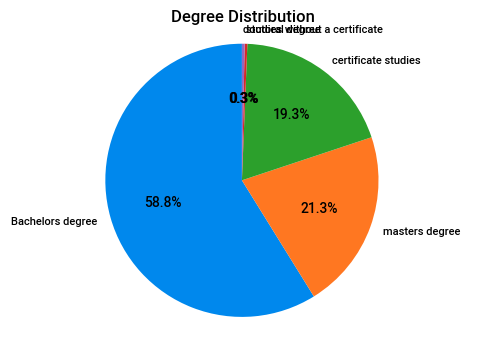

In [23]:
# Data for the cake graph
labels = ['Bachelors degree', 'masters degree', 'certificate studies', 'studies without a certificate', 'doctoral degree']
sizes = data_nurses['Degree'].value_counts(normalize=True) * 100

labels = list(labels)
sizes = sizes.tolist()

# Create the cake graph
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Degree Distribution')

# Display the graph
plt.axis('equal')  # Ensure the cake graph is circular
plt.show()

In [24]:
table = pd.pivot_table(data_nurses, values='ID', index=['Degree'], columns=['Course'], aggfunc='count')

total_per_degree = table.sum(axis=1)
percentage_table = table.apply(lambda x: round((x / total_per_degree[x.name]) * 100, 2), axis=1)

percentage_table

Course,0,1,2,3,4,5,6
Degree,,,,,,,
לימודי תעודה,78.45,12.71,7.73,0.55,NaN,0.55,NaN
לימודים ללא תעודה,100.00,NaN,NaN,NaN,NaN,NaN,NaN
תואר ראשון,41.05,33.27,20.25,3.07,2.17,NaN,0.18
תואר שלישי,33.33,66.67,NaN,NaN,NaN,NaN,NaN
תואר שני,18.50,27.50,34.00,12.50,6.50,NaN,1.00
